In [1]:
import numpy as np
from qepy.io import QEInput
from qepy.driver import Driver
#from ase.io.trajectory import Trajectory
from ase.io.trajectory import Trajectory
from ase.build import bulk
from ase import Atoms
import matplotlib.pyplot as plt
import time

In [2]:
from ase.units import kJ
from ase.eos import EquationOfState

In [3]:
from ase.io import read

In [4]:
atoms = read('/projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/Li/oxide/Li2O.poscar')

In [5]:
alats = [0.8,0.85,0.9,0.95,0.975,1.0,1.025,1.05,1.075,1.1,1.15,1.2]

In [ ]:
qe_options = {
    '&control': {
        'calculation': "'scf'",
        'prefix': "'gbrv'",
        'pseudo_dir': "'/projectsn/mp1009_1/Valeria/NLPP/PP/'"},
    '&system': {
        'ibrav' : 0,
        'degauss': 0.02,
        # 'input_dft': "'pbe'",
        'ecutwfc': 80,
        'occupations': "'smearing'",
        'smearing': "'fermi-dirac'" 
    },
    '&electrons': {
        'conv_thr' : 1.0e-10,
        'mixing_beta': 0.3,},
     'atomic_species': ['Li 6.94 li_lda_v1.4.uspp.F.UPF', 'O 15.999 o_lda_v1.2.uspp.F.UPF'],
     'k_points automatic': ['4 4 4 0 0 0'],
}


qe_options = QEInput.update_atoms(atoms, qe_options = qe_options,  extrapolation=False)
QEInput().write_qe_input('gbrv.in', qe_options=qe_options)
start_time = time.time()
driver = Driver(qe_options=qe_options, atoms=atoms, logfile='gbrv.out')


In [ ]:
alats = [0.8,0.85,0.9,0.95,0.975,1.0,1.025,1.05,1.075,1.1,1.15,1.2]
ks_ene = []
ks_rho = []
vol = []
# atoms = bulk('Li', 'bcc', 3.51)
for x in alats:
    print(x)
    ta=atoms.copy()
    ta.cell *= x
    qe_options = QEInput.update_atoms(ta, qe_options = qe_options,  extrapolation=False)
    QEInput().write_qe_input('qe/'+str(x)+'.in', qe_options=qe_options)
    driver = Driver('qe/'+str(x)+'.in', logfile='qe/'+str(x)+'.out')
    driver.scf()
    ene = driver.get_energy()
    driver.stop()
    ks_ene.append(ene)
    vol.append(ta.get_volume())

ee=np.array(ks_ene)
vv=np.asarray(vol)
np.save('energy.npy', ee)
np.save('volume.npy', vv)

In [6]:
ee=np.load('energy.npy')
vv=np.load('volume.npy')


In [7]:
ee_eos= EquationOfState(vv/1, ee*27.211385/2, eos='murnaghan') 
vv0, ee0, B = ee_eos.fit()
eos = [ vv0, ee0, B / kJ * 1.0e24]

<AxesSubplot: title={'center': 'murnaghan: E: -3328.425 eV, V: 94.891 Å$^3$, B: 218.171 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

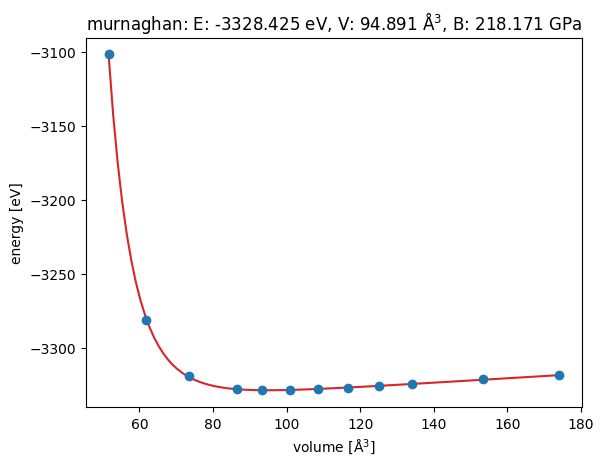

In [8]:
ee_eos.plot()

In [9]:
# Batteries/Li2S_interface/OF/Li/metal/PP/OEPP/LDA/tf02vw/lda_tf02vw.psp8

In [10]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from dftpy.functional.pseudo.psp import PSP
from dftpy.constants import environ
from ase.build import bulk
import numpy as np
from scipy.optimize import minimize
from scipy.signal import quadratic
from dftpy.api.api4ase import DFTpyCalculator
from dftpy.config import DefaultOption, OptionFormat

In [11]:
from dftpy.constants import environ

In [12]:
environ['LOGLEVEL'] = 4

In [13]:
e_revhc = []
v_revhc = []
for alat in alats: 
    print(alat)
    atoms = atoms.copy()#bulk('Li', 'bcc', 3.51)
    conf = DefaultOption()
    conf['PATH']['pppath'] = '/projectsn/mp1009_1/Valeria/NLPP/PP/'
    conf['PP']['Li'] = 'li_lda_v1.4.uspp.F.UPF'
    conf['PP']['O'] = 'o_lda_v1.2.uspp.F.UPF'
    conf['EXC']['xc'] = 'LDA'
    conf['OPT']['method'] = 'CG'
    conf['OPT']['algorithm'] = 'OESCF'
    conf['KEDF']['kedf'] = 'revHC'
    conf['JOB']['calctype'] = 'Energy Force'
    conf['OPT']['econv'] = 1.e-11
    conf['GRID']['ecut'] = 1600
    conf = OptionFormat(conf)
    calc = DFTpyCalculator(config=conf)
    atoms.set_calculator(calc)
    tta=atoms.copy()   
    tta.cell *= alat
    tta.set_calculator(calc)
    e_revhc.append(tta.get_potential_energy())
    v_revhc.append(tta.get_volume())

e_revhc=np.array(e_revhc)
v_revhc=np.asarray(v_revhc)
np.save('energy_revhc_li20_gbrv.npy', e_revhc)
np.save('volume_revhc_li20_gbrv.npy', v_revhc)

0.8


/tmp/ipykernel_53999/620034721.py:19: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)
/tmp/ipykernel_53999/620034721.py:22: DeprecationWarning: Please use atoms.calc = calc
  tta.set_calculator(calc)


0.85
0.9
0.95
0.975
1.0
1.025
1.05
1.075
1.1
1.15
1.2


In [14]:
e_revhc=np.load('energy_revhc_li20_gbrv.npy')
v_revhc=np.load('volume_revhc_li20_gbrv.npy')

In [15]:
eos_revhc= EquationOfState(v_revhc/1, e_revhc, eos='murnaghan') 
v0_revhc, e0_revhc, B_revhc = eos_revhc.fit()
eos = [ vv0, ee0, B / kJ * 1.0e24]

<AxesSubplot: title={'center': 'murnaghan: E: -2567.383 eV, V: 84.550 Å$^3$, B: 475.762 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

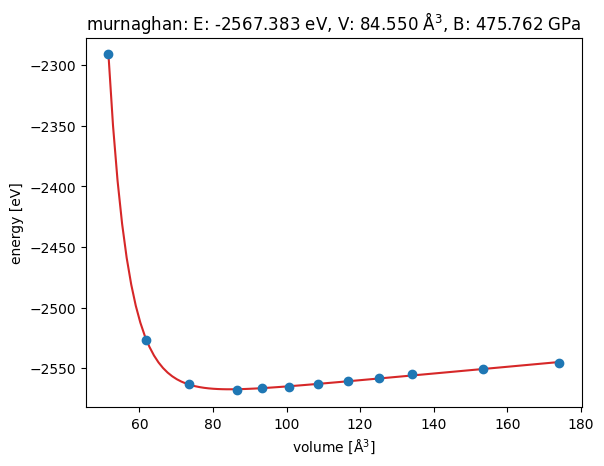

In [16]:
eos_revhc.plot()

In [17]:
e_tf02vw = []
v_tf02vw = []
for alat in alats: 
    print(alat)
    atoms = atoms.copy()
    conf = DefaultOption()
    conf['PATH']['pppath'] = '/projectsn/mp1009_1/Valeria/NLPP/PP/'
    conf['PP']['Li'] = 'li_lda_v1.4.uspp.F.UPF'
    conf['PP']['O'] = 'o_lda_v1.2.uspp.F.UPF'
    conf['EXC']['xc'] = 'LDA'
    conf['OPT']['method'] = 'CG'
    conf['OPT']['algorithm'] = 'OESCF'
    conf['KEDF']['kedf'] = 'TFvW'
    conf['KEDF']['y'] = 0.2
    conf['JOB']['calctype'] = 'Energy Force'
    conf['OPT']['econv'] = 1.e-11
    conf['GRID']['ecut'] = 1600
    conf = OptionFormat(conf)
    calc = DFTpyCalculator(config=conf)
    atoms.set_calculator(calc)
    tta=atoms.copy()   
    tta.cell *= alat
    tta.set_calculator(calc)
    e_tf02vw.append(tta.get_potential_energy())
    v_tf02vw.append(tta.get_volume())

e_tf02vw=np.array(e_tf02vw)
v_tf02vw=np.asarray(v_tf02vw)
np.save('energy_tf02vw_li2o_gbrv.npy', e_tf02vw)
np.save('volume_tf02vw_li2o_gbrv.npy', v_tf02vw)

0.8


/tmp/ipykernel_53999/3628498844.py:20: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)
/tmp/ipykernel_53999/3628498844.py:23: DeprecationWarning: Please use atoms.calc = calc
  tta.set_calculator(calc)


0.85
0.9


/home/vr371/.local/lib/python3.8/site-packages/dftpy/mixer/pulay.py:80: LinAlgWarning: Ill-conditioned matrix (rcond=3.74776e-25): result may not be accurate.
  x = linalg.solve(amat, b, assume_a = 'sym')


0.95
0.975
1.0
1.025
1.05
1.075
1.1
1.15
1.2


In [18]:
e_tf02vw=np.load('energy_tf02vw_li2o_gbrv.npy')
v_tf02vw=np.load('volume_tf02vw_li2o_gbrv.npy')

<AxesSubplot: title={'center': 'murnaghan: E: -2355.838 eV, V: 78.377 Å$^3$, B: 1125.486 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

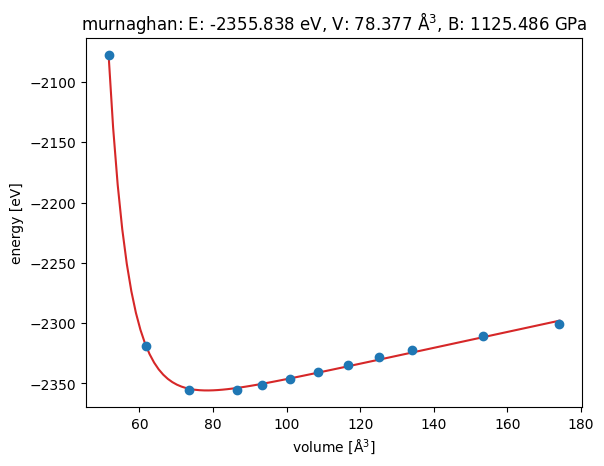

In [19]:
eos_tf02vw= EquationOfState(v_tf02vw/1, e_tf02vw, eos='murnaghan') 
v0_tf02vw, e0_tf02vw, B_tf02vw = eos_tf02vw.fit()
eos = [ vv0, ee0, B / kJ * 1.0e24]
eos_tf02vw.plot()

In [20]:
alats = [0.8,0.85,0.9,0.95,0.975,1.0,1.025,1.05,1.075,1.1,1.15,1.2]
e_lmgp = []
v_lmgp = []
for alat in alats: 
    print(alat)
    atoms = atoms.copy()
    conf = DefaultOption()
    conf['PATH']['pppath'] = '/projectsn/mp1009_1/Valeria/NLPP/PP/'
    conf['PP']['Li'] = 'li_lda_v1.4.uspp.F.UPF'
    conf['PP']['O'] = 'o_lda_v1.2.uspp.F.UPF'
    conf['EXC']['xc'] = 'LDA'
    conf['OPT']['method'] = 'CG'
    conf['OPT']['algorithm'] = 'OESCF'
    conf['KEDF']['kedf'] = 'LMGP'
    # conf['KEDF']['y'] = 0.2
    conf['JOB']['calctype'] = 'Energy Force'
    conf['OPT']['econv'] = 1.e-11
    conf['GRID']['ecut'] = 1600
    conf = OptionFormat(conf)
    calc = DFTpyCalculator(config=conf)
    atoms.set_calculator(calc)
    tta=atoms.copy()   
    tta.cell *= alat
    tta.set_calculator(calc)
    e_lmgp.append(tta.get_potential_energy())
    v_lmgp.append(tta.get_volume())

e_lmgp=np.array(e_lmgp)
v_lmgp=np.asarray(v_lmgp)
np.save('energy_lmgp_li2o_gbrv.npy', e_lmgp)
np.save('volume_lmgp_li2o_gbrv.npy', v_lmgp)

0.8


/tmp/ipykernel_53999/2204326461.py:21: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)
/tmp/ipykernel_53999/2204326461.py:24: DeprecationWarning: Please use atoms.calc = calc
  tta.set_calculator(calc)


0.85
0.9
0.95
0.975
1.0
1.025
1.05
1.075
1.1
1.15
1.2


In [21]:
eos_lmgp= EquationOfState(v_lmgp/1, e_lmgp, eos='murnaghan') 
v0_lmgp, e0_lmgp, B_lmgp = eos_lmgp.fit()
eos = [ vv0, ee0, B / kJ * 1.0e24]
eos_lmgp.plot()

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [24]:
import pandas as pd

In [22]:
kedfs = ['KS', 'revHC', 'TF02vW', 'LMGP']
e0 = [ee0, e0_revhc, e0_tf02vw, 'nan']
v0 = [vv0, v0_revhc, v0_tf02vw, 'nan']
B0 = [B, B_revhc, B_tf02vw,'nan']
eos = {}
for i,ke in enumerate(kedfs):
    if ke=='LMGP':
        eos[ke] = [v0[i], e0[i], B0[i]]
    else:
        eos[ke] = [v0[i], e0[i], B0[i]/ kJ * 1.0e24]

In [25]:
df = pd.DataFrame.from_dict(eos, orient='index', columns=[ 'Volume ($A^3$)', 'Energy (eV)', 'Bulk modulos (GPa)'])
df.reset_index(inplace=False)
df.rename(columns={'index': 'Element'}, inplace=True)
df.style\
    .format(precision=3, decimal=".")

,Volume ($A^3$),Energy (eV),Bulk modulos (GPa)
KS,94.891,-3328.425,218.171
revHC,84.550,-2567.383,475.762
TF02vW,78.377,-2355.838,1125.486
LMGP,nan,nan,nan


Text(0.5, 0, 'Volume ($A^{3}$)')

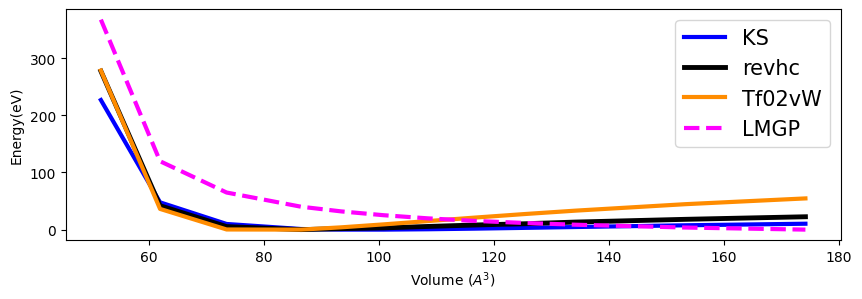

In [26]:
fig, axs = plt.subplots(1, 1, figsize=(10, 3))

plt.plot(vv, ee*27.211385/2-min(ee*27.211385/2), ls='-', lw=3,color='b',label='KS')
plt.plot(v_revhc, e_revhc-min(e_revhc), color='k', lw=3.5, label='revhc')
plt.plot(v_tf02vw, e_tf02vw-min(e_tf02vw), color='darkorange', lw=3.0, label='Tf02vW')
plt.plot(v_lmgp, e_lmgp-min(e_lmgp), ls='--', lw=3.0,color='magenta',label='LMGP')
plt.legend(fontsize=15)
plt.ylabel('Energy(eV)')
plt.xlabel('Volume ($A^{3}$)')
